In [1]:
import seaborn as sns
import pymongo as pm
import matplotlib.pyplot as plt
from pprint import pprint
from wordcloud import WordCloud
from pymongo import MongoClient

def draw_barplot(x, y, xlabel, ylabel):
    f, ax = plt.subplots(figsize=(10, 5))
    ax.set(xlabel=xlabel, ylabel=ylabel)
    sns.barplot(x=x, y=y, color="b")
    
def filter_words(l, name, count):
    counts = list()
    names = list()
    for d in l:
        if d[name] not in bad_words and d[name] not in names:
            counts.append(d[count])
            names.append(d[name])
    return [names, counts]

sns.set(style="whitegrid")
client = MongoClient("localhost:27017")
collection = client.Urbaner.dictionary

bad_words = ["sexy", "fuck", "bitch", "ass", "penis", "vagina", "shit", "cunt", "gay", "nigger", "asshole",
             "anal", "anus", "blowjob", "whore", "slut", "pussy", "cock", "boner", "cum", "dick",
             "fag", "faggot", "ho", "hoe", "homo", "jizz", "nigga", "tits", "porn", "orgasm", "feminism",
             "skank", "poop", "booty", "balls", "crap", "fart", "boobs", "butt", "black",
             "asian", "sex", "fucktard", "chode", "gate rape", "muslim", "feminist", "Anonymous",
             "anonymous", "rape", "islam"]

In [2]:
# Query 1: Do critical fields exist in all documents?
l = ["_id", "lowercase_word", "tags", "thumbs_up", "thumbs_down", "author"]

for i in l:
    print("{} - {} ".format(i, collection.count_documents({i : {"$exists" : False}})))

_id - 0 
lowercase_word - 0 
tags - 0 
thumbs_up - 0 
thumbs_down - 0 
author - 0 


In [3]:
# Query 2: Are the critical fields NULL or empty?
l = ["_id", "lowercase_word", "tags", "thumbs_up", "thumbs_down", "author"]

for i in l:
    print("{} - {} ".format(i, collection.count_documents({i : None})))

print("Number of documents with empty tags field: ", collection.count_documents({"tags":[]}))

_id - 0 
lowercase_word - 0 
tags - 0 
thumbs_up - 0 
thumbs_down - 0 
author - 0 
Number of documents with empty tags field:  734948


In [4]:
# Query 3: Is the data type of each field correct?
print("_id - {}".format(collection.count_documents({"_id" : { "$not" : {"$type" : "objectId"}}})))
print("lowercase_word - {}".format(collection.count_documents(
    {"lowercase_word" : { "$not" : {"$type" : "string"}}})))
print("tags - {}".format(collection.count_documents({"tags" : { "$not" : {"$type" : "array"}}})))
print("thumbs_up - {}".format(collection.count_documents({"thumbs_up" : { "$not" : {"$type" : "int"}}})))
print("thumbs_down - {}".format(collection.count_documents({"thumbs_down" : { "$not" : {"$type" : "int"}}})))
print("author - {}".format(collection.count_documents({"author" : { "$not" : {"$type" : "string"}}})))

_id - 0
lowercase_word - 0
tags - 0
thumbs_up - 0
thumbs_down - 0
author - 0


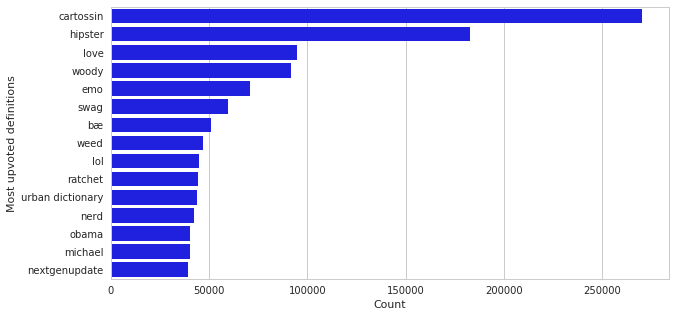

In [5]:
# Query 4: What are the most upvoted definitions?
result = collection.find(
    {}, {"_id":0, "lowercase_word":1, "thumbs_up":1}).sort(
    "thumbs_up", pm.DESCENDING).limit(100)
result_to_list = list(result)
names, counts = filter_words(result_to_list, "lowercase_word", "thumbs_up")
draw_barplot(counts[0:15], names[0:15], "Count", "Most upvoted definitions")

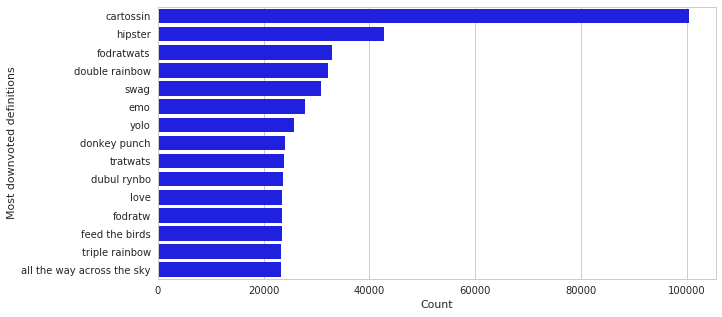

In [6]:
# Query 5: What are the most downvoted definitions?
result = collection.find(
    {}, {"_id":0, "lowercase_word":1, "thumbs_down":1}).sort(
    "thumbs_down", pm.DESCENDING).limit(100)
result_to_list = list(result)
names, counts = filter_words(result_to_list, "lowercase_word", "thumbs_down")
draw_barplot(counts[0:15], names[0:15], "Count", "Most downvoted definitions")

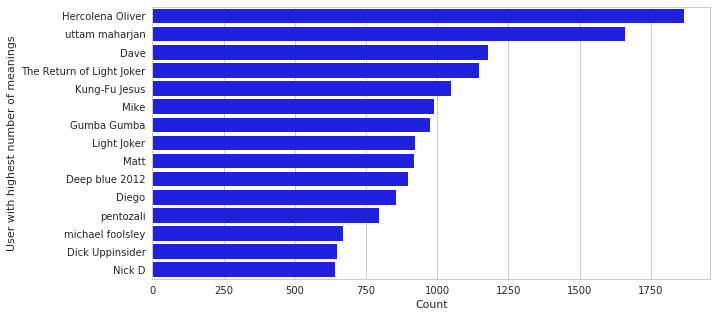

In [7]:
# Query 6: Who are the users who have written the highest number of meanings?
pipeline = [{"$sortByCount" : "$author"}, {"$limit":30}]
result = collection.aggregate(pipeline, allowDiskUse = True)
result_to_list = list(result)
names, counts = filter_words(result_to_list, "_id", "count")
draw_barplot(counts[0:15], names[0:15], "Count", "User with highest number of meanings")

(-0.5, 399.5, 199.5, -0.5)

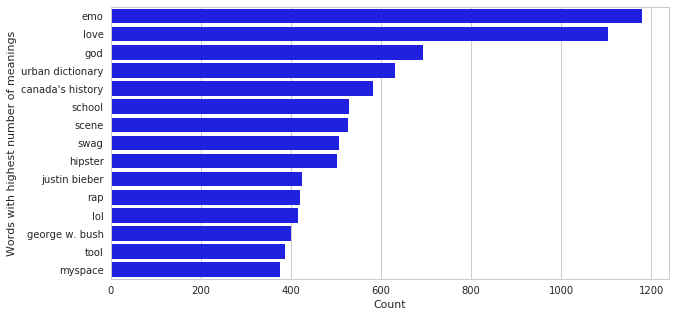

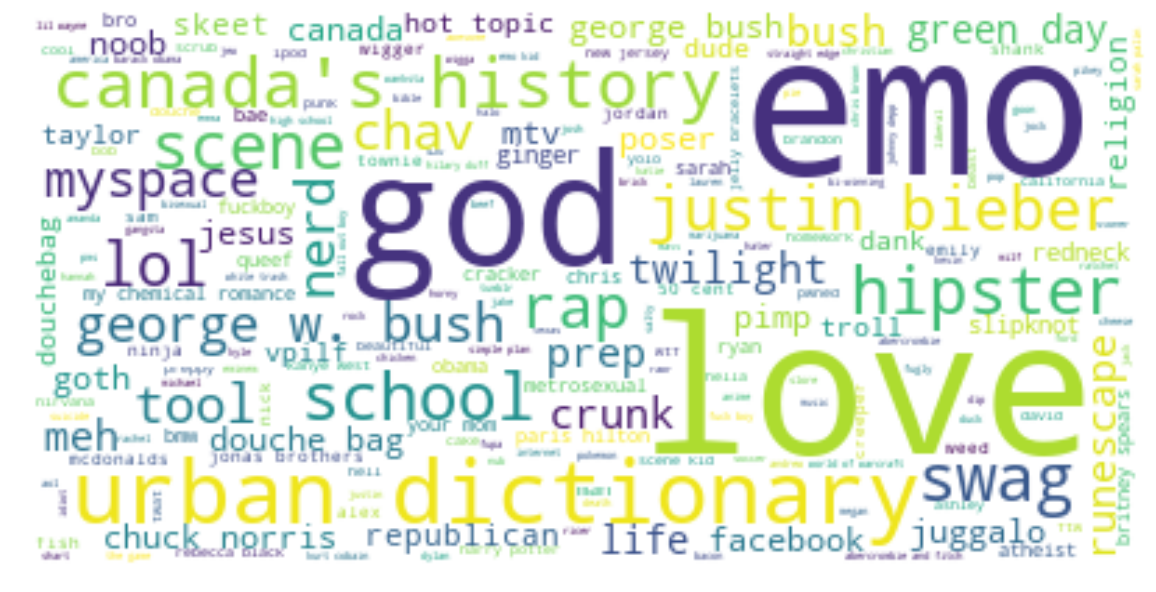

In [8]:
# Query 7: What are the words that have the highest number of meanings?
pipeline = [{"$sortByCount" : "$lowercase_word"}, {"$limit":1000}]
result = collection.aggregate(pipeline, allowDiskUse = True)
result_to_list = list(result)
names, counts = filter_words(result_to_list, "_id", "count")
draw_barplot(counts[0:15], names[0:15], "Count", "Words with highest number of meanings")

count_dict = {}
for i in result_to_list:
    count_dict[i["_id"]] = i["count"]
clean_dict = {key: count_dict[key] for key in count_dict if key not in bad_words}
wc = WordCloud(background_color="white", max_font_size=70).generate_from_frequencies(clean_dict)
plt.figure(figsize=(20,20))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

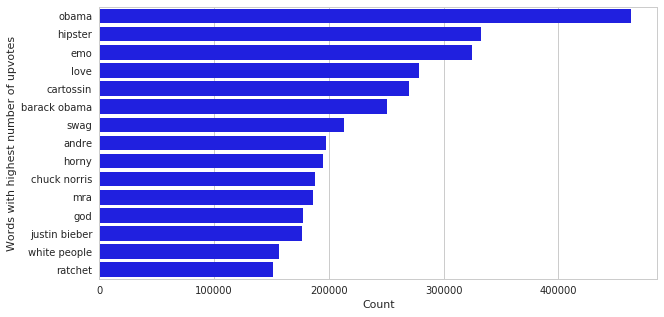

In [9]:
# Query 8: Which words have the overall highest number of upvotes?
#(Includes definitions written by multiple users)

pipeline = [
    {
      "$group": {
        "_id" : "$lowercase_word",
        "total_upvotes": { "$sum": "$thumbs_up" },
      }
    },
    {"$sort": {"total_upvotes":-1}},
    {"$limit": 100}
  ]

result = collection.aggregate(pipeline, allowDiskUse = True)
result_to_list = list(result)
names, counts = filter_words(result_to_list, "_id", "total_upvotes")
draw_barplot(counts[0:15], names[0:15], "Count", "Words with highest number of upvotes")

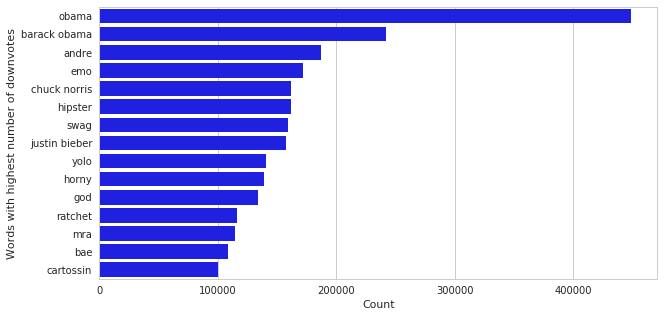

In [10]:
# Query 9: Which words have the overall highest number of downvotes?
# (Includes definitions written by multiple users)

pipeline = [
    {
      "$group": {
        "_id" : "$lowercase_word",
        "total_downvotes": { "$sum": "$thumbs_down" },
      }
    },
    {"$sort": {"total_downvotes":-1}},
    {"$limit": 100}
  ]

result = collection.aggregate(pipeline, allowDiskUse = True)
result_to_list = list(result)
names, counts = filter_words(result_to_list, "_id", "total_downvotes")
draw_barplot(counts[0:15], names[0:15], "Count", "Words with highest number of downvotes")


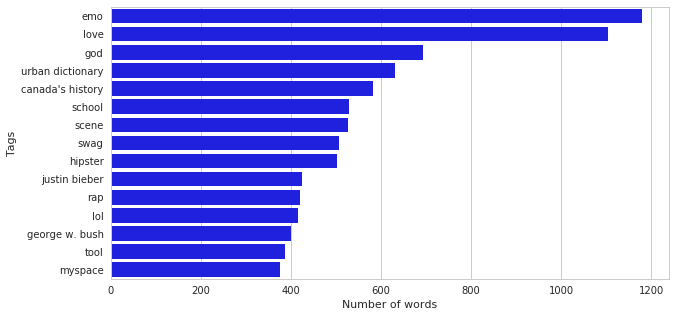

In [11]:
# Query 10: What are the most popular tags? (Popular = have most words)
pipeline =   [
    {
      "$group": {
        "_id" : "$lowercase_word",
        "count": { "$sum": 1 }
      }
    },
    {"$sort": {"count":-1}},
    {"$limit": 100}
  ]

result = collection.aggregate(pipeline, allowDiskUse = True)
result_to_list = list(result)
names, counts = filter_words(result_to_list, "_id", "count")
draw_barplot(counts[0:15], names[0:15], "Number of words", "Tags")

(-0.5, 399.5, 199.5, -0.5)

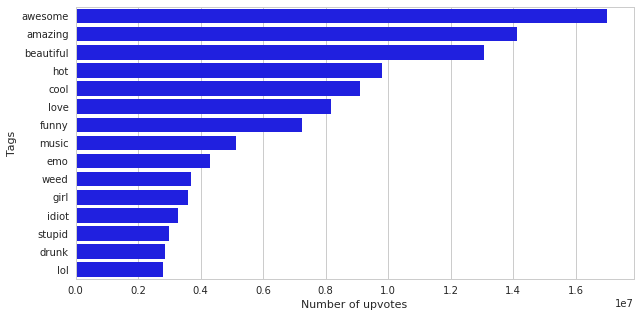

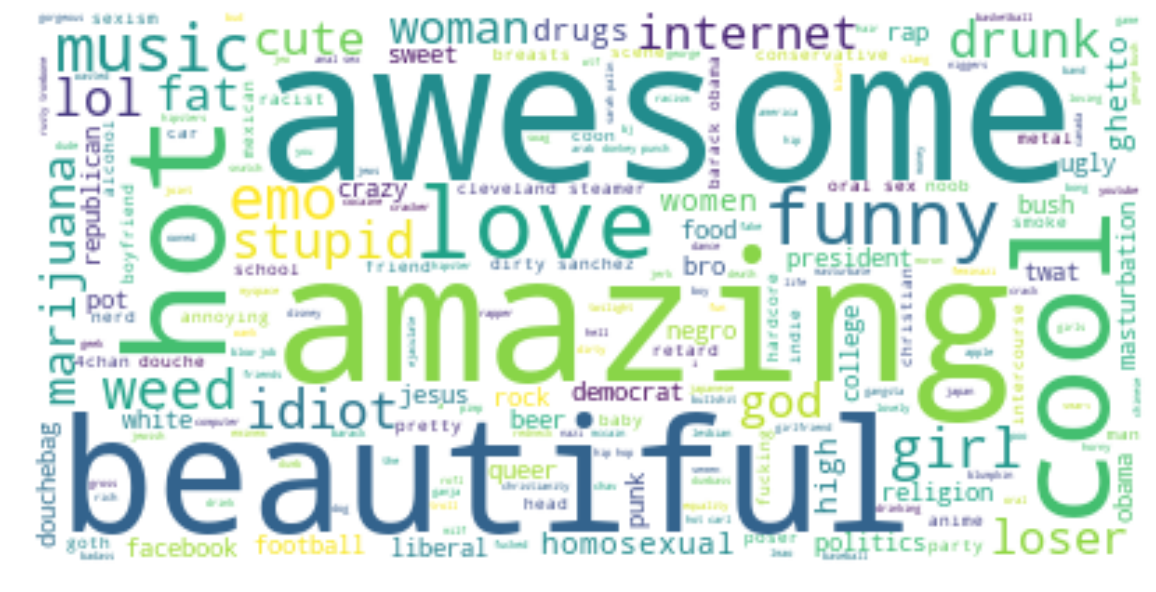

In [12]:
# Query 11: What are the most successful tags? (Successful = have words with most upvotes)
pipeline =  [
    {"$unwind":"$tags"},
    {
      "$group": {
        "_id" : "$tags",
        "total_upvotes": { "$sum": "$thumbs_up" }
      }
    },
    {"$sort": {"total_upvotes":-1}},
    {"$limit": 1000}
  ]

result = collection.aggregate(pipeline, allowDiskUse = True)
result_to_list = list(result)
names, counts = filter_words(result_to_list, "_id", "total_upvotes")
draw_barplot(counts[0:15], names[0:15], "Number of upvotes", "Tags")

count_dict = {}
for i in result_to_list:
    count_dict[i["_id"]] = i["total_upvotes"]
clean_dict = {key: count_dict[key] for key in count_dict if key not in bad_words}
wc = WordCloud(background_color="white", max_font_size=70).generate_from_frequencies(clean_dict)
plt.figure(figsize=(20,20))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

In [13]:
# Query 12: Based on number of upvotes and downvotes, how can we rank the meanings of a particular word?
pprint(list(collection.find(
    {"lowercase_word":"love"}, {"definition":1, "ratio":1, "_id":0}).sort("ratio", pm.DESCENDING).limit(5)))

[{'definition': 'A misunderstanding between two fools.',
  'ratio': 0.9333333333333333},
 {'definition': 'The most spectacular,indescribable,  deep euphoric feeling '
                'for someone. \r\n'
                '\r\n'
                "Love is an incredibly powerful word. When you're in love, you "
                "always want to be together, and when you're not, you're "
                'thinking about being together because you need that person '
                'and without them your life is incomplete.\r\n'
                '\r\n'
                'This love is unconditional affection with no limits or '
                "conditions: completely loving someone. It's when you trust "
                'the other with your life and when you would do anything for '
                'each other. When you love someone you want nothing more than '
                'for them to be truly happy no matter what it takes because '
                "that's how much you care about them and because